# Project 1: Clustering with SOM
## Imports and Setup

Basic imports, sklearn utilities, MiniSom, and matplotlib configuration. Includes robust MiniSom import/installation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from minisom import MiniSom

np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

## Data Loading and Preparation

Load the digits dataset, scale the features, and split into training, validation, and test sets (60/20/20 split).

In [2]:
# Load the digits dataset
digits = load_digits()
X = digits.data # Original data (8x8=64 features)
y = digits.target # Labels (0-9)
print(f"Digits dataset loaded: {X.shape[0]} samples, {X.shape[1]} features.")
print(f"Number of classes: {len(np.unique(y))}")

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
print(f"Data scaled using {type(scaler).__name__}.")

# 1. Split into Initial Train and Final Test sets
X_train_init, X_test, y_train_init, y_test, X_train_init_orig, X_test_orig = train_test_split(
    X_scaled, y, X, # Split scaled X, y, AND original X
    test_size=0.2,    # 80% initial train, 20% final test
    random_state=42,
    stratify=y )
print(f"Initial data split: Initial Train ({X_train_init.shape[0]}), Final Test ({X_test.shape[0]})")

# 2. Split Initial Train into Final Train and Validation sets
X_train_final, X_val, y_train_final, y_val, X_train_final_orig, X_val_orig = train_test_split(
    X_train_init, y_train_init, X_train_init_orig, # Split initial train data (scaled and original)
    test_size=0.25,
    random_state=42,
    stratify=y_train_init
)
print(f"Train/Validation split: Final Train ({X_train_final.shape[0]}), Validation ({X_val.shape[0]})")
print("Digits data prepared and split into Train/Validation/Test sets.")
print("-" * 30)

Digits dataset loaded: 1797 samples, 64 features.
Number of classes: 10
Data scaled using MinMaxScaler.
Initial data split: Initial Train (1437), Final Test (360)
Train/Validation split: Final Train (1077), Validation (360)
Digits data prepared and split into Train/Validation/Test sets.
------------------------------


## SOM Implementation & Training

Define SOM parameters and train two SOMs (4x4 and 20x20) on the final training data. Quantization Error on train and validation sets is calculated. Hyperparameters should be tuned based on validation performance (QE and classification accuracy from Task 2 validation).

In [3]:
# Define SOM parameters
som_grid_size_small = (4, 4)
som_grid_size_large = (20, 20)
n_features = X_train_final.shape[1] 

# Hyperparameters for Small SOM
sigma_small = 1.0
lr_small = 0.5              
iterations_small = 10000
init_method_small = "PCA"

# Hyperparameters for Large SOM
sigma_large = 3.0
lr_large = 0.5             
iterations_large = 15000
init_method_large = "Random"

print("SOM Hyperparameters defined:")
print(f"  Small (4x4): Sigma={sigma_small}, LR={lr_small}, Iter={iterations_small}, Init={init_method_small}")
print(f"  Large (20x20): Sigma={sigma_large}, LR={lr_large}, Iter={iterations_large}, Init={init_method_large}")
print("-" * 30)

SOM Hyperparameters defined:
  Small (4x4): Sigma=1.0, LR=0.5, Iter=10000, Init=PCA
  Large (20x20): Sigma=3.0, LR=0.5, Iter=15000, Init=Random
------------------------------


### Train Small SOM (4x4)

In [4]:
import warnings

print(f"\n--- Configuring and Training 4x4 SOM ---")
print(f"Grid: {som_grid_size_small}, Sigma: {sigma_small}, LR: {lr_small}, Iter: {iterations_small}, Init: {init_method_small}")

# Instantiate the SOM
som_small = MiniSom(x=som_grid_size_small[0], y=som_grid_size_small[1],
                   input_len=n_features, sigma=sigma_small, learning_rate=lr_small,
                   neighborhood_function='gaussian', random_seed=42)

if init_method_small == "PCA":
    print("Initializing weights using PCA...")
    warnings.filterwarnings("ignore")
    som_small.pca_weights_init(X_train_final)
else:
    print("Initializing weights randomly...")
    som_small.random_weights_init(X_train_final)

# Train the SOM
print(f"Training for {iterations_small} iterations...")
# Train on the FINAL training data
som_small.train_random(X_train_final, iterations_small, verbose=False) 
# Calculate Quantization Error 
qe_small_train = som_small.quantization_error(X_train_final)
qe_small_val = som_small.quantization_error(X_val) # Evaluate QE also on validation set
print(f"Training completed!")
print(f"Quantization Error (Small SOM): Train QE = {qe_small_train:.4f}, Validation QE = {qe_small_val:.4f}")
print("-" * 30)


--- Configuring and Training 4x4 SOM ---
Grid: (4, 4), Sigma: 1.0, LR: 0.5, Iter: 10000, Init: PCA
Initializing weights using PCA...
Training for 10000 iterations...
Training completed!
Quantization Error (Small SOM): Train QE = 1.5233, Validation QE = 1.5735
------------------------------


### Train Large SOM (20x20)

In [5]:
print(f"\n--- Configuring and Training 20x20 SOM ---")
print(f"Grid: {som_grid_size_large}, Sigma: {sigma_large}, LR: {lr_large}, Iter: {iterations_large}, Init: {init_method_large}")

# Instantiate the SOM
som_large = MiniSom(x=som_grid_size_large[0], y=som_grid_size_large[1],
                   input_len=n_features, sigma=sigma_large, learning_rate=lr_large,
                   neighborhood_function='gaussian', random_seed=42)

# Initialize weights
if init_method_large == "PCA":
    print("Initializing weights using PCA...")
    som_large.pca_weights_init(X_train_final)
else:
    print("Initializing weights randomly...")
    som_large.random_weights_init(X_train_final)

# Train the SOM
print(f"Training for {iterations_large} iterations...")
# Train on the FINAL training data
som_large.train_random(X_train_final, iterations_large, verbose=False) # Set verbose=True to see progress

# Calculate Quantization Error (Task 1, Step 6)
qe_large_train = som_large.quantization_error(X_train_final)
qe_large_val = som_large.quantization_error(X_val) # Evaluate QE also on validation set
print(f"Training completed!")
print(f"Quantization Error (Large SOM): Train QE = {qe_large_train:.4f}, Validation QE = {qe_large_val:.4f}")
print("-" * 30)


--- Configuring and Training 20x20 SOM ---
Grid: (20, 20), Sigma: 3.0, LR: 0.5, Iter: 15000, Init: Random
Initializing weights randomly...
Training for 15000 iterations...
Training completed!
Quantization Error (Large SOM): Train QE = 1.1078, Validation QE = 1.2183
------------------------------


## Visualization and Analysis Functions

Define helper functions for visualizing SOM results (Hit Maps, Dead Neurons, Sample Images) and for Task 2 (Label Assignment, Classification & Evaluation).

In [9]:
def visualize_som_clusters(som, X_scaled_map, y_map, X_orig_display, grid_size, title):
    print(f"\n--- Visualizing SOM Clusters: {title} ---")
    rows, cols = grid_size

    mapped_positions_cr = [som.winner(x) for x in X_scaled_map]

    # Create a map to store which data indices map to each neuron
    neuron_map = {(c, r): [] for c in range(cols) for r in range(rows)}
    for idx, pos_cr in enumerate(mapped_positions_cr):
        if 0 <= pos_cr[0] < cols and 0 <= pos_cr[1] < rows:
             neuron_map[pos_cr].append(idx)

    # 1. Visualize Hit Map (Task 1, Step 5 - Hit Maps)
    plt.figure(figsize=(max(6, cols * 0.6), max(6, rows * 0.6))) # Adjust size based on grid
    plt.title(f'Hit Map - {title} ({rows}x{cols})')
    hit_map = np.zeros((rows, cols), dtype=int)
    for pos_cr, indices in neuron_map.items():
        col, row = pos_cr
        if 0 <= row < rows and 0 <= col < cols: 
             hit_map[row, col] = len(indices)

    print(f"Hit Map Analysis ({title}):")
    print(f"  Min hits per neuron = {np.min(hit_map)}")
    print(f"  Max hits per neuron = {np.max(hit_map)}")
    print(f"  Avg hits per neuron = {np.mean(hit_map):.2f}")

    # Plot the hit map using imshow (row-major order)
    im = plt.imshow(hit_map, cmap='viridis', origin='upper', interpolation='nearest')
    plt.colorbar(im, label='Number of Samples Mapped')

    # Identify and mark dead neurons (zero hits)
    dead_neurons = []
    plotted_legend = False
    for r in range(rows):
        for c in range(cols):
            # Check if the neuron has zero hits
            if hit_map[r, c] == 0:
                pos_cr = (c, r) # (col, row) coordinate
                dead_neurons.append(pos_cr)
                # Mark dead neurons on the hit map
                plt.scatter(c, r, marker='x', color='red', s=60, label='Dead Neuron' if not plotted_legend else "")
                plotted_legend = True # Ensure legend only appears once

    if dead_neurons:
        plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), 
                   fontsize=8, ncol=1)

    plt.xticks(np.arange(cols))
    plt.yticks(np.arange(rows))
    plt.xlabel("Neuron Column Index")
    plt.ylabel("Neuron Row Index")
    plt.grid(True, which='both', color='gray', linewidth=0.5, linestyle=':')
    plt.show()

    # Report dead neurons
    num_dead_neurons = len(dead_neurons)
    total_neurons = rows * cols
    print(f"Number of dead neurons found: {num_dead_neurons} ({num_dead_neurons/total_neurons*100:.1f}%)")

    # 2. Visualize Sample Images per Neuron (Task 1, Step 5 - Sample Images & Interpretation)
    print(f"\nGenerating sample images plot for {title}...")
    fig_samples, axes = plt.subplots(rows, cols, figsize=(max(10, cols), max(10, rows)),
                                     subplot_kw={'xticks': [], 'yticks': []}) # No ticks on image subplots
    fig_samples.suptitle(f'Sample Images & Majority Label per Neuron - {title}', fontsize=16)

    neuron_labels_map = {}

    for r in range(rows):
        for c in range(cols):
            ax = axes[r, c] if rows > 1 and cols > 1 else (axes[max(r,c)] if max(rows,cols)>1 else axes) # Handle single row/col/neuron case
            pos_cr = (c, r)

            if pos_cr in neuron_map and neuron_map[pos_cr]:
                indices = neuron_map[pos_cr]
                labels_mapped = y_map[indices]
                neuron_labels_map[pos_cr] = labels_mapped.tolist()
                # Display the first sample mapped to this neuron
                sample_idx = indices[0]
                img = X_orig_display[sample_idx].reshape(8, 8) # Use original data for display
                ax.imshow(img, cmap='binary') # Display grayscale image

                # Annotate with neuron info (coordinates, count, majority label)
                if labels_mapped.size > 0:
                    unique_labels, counts = np.unique(labels_mapped, return_counts=True)
                    majority_label = unique_labels[np.argmax(counts)]
                    # Create a string representation of label counts for the title
                    label_counts_str = "/".join([f"{lbl}:{cnt}" for lbl, cnt in zip(unique_labels, counts)])
                    # Dynamic font size based on grid size
                    fontsize = max(4, 10 - max(rows, cols)//2)
                    ax.set_title(f"({c},{r}): N={len(indices)}\nMaj={majority_label} ({label_counts_str})", fontsize=fontsize)
                else:
                    ax.set_title(f"({c},{r}): N=0\nLbl=?", fontsize=max(4, 10 - max(rows, cols)//2))
            else:
                # Mark dead neurons visually in the samples plot
                ax.set_title(f"({c},{r}): Dead", fontsize=max(4, 10 - max(rows, cols)//2))
                ax.set_facecolor('lightgrey') # Gray background for dead neurons

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()
    return neuron_labels_map, dead_neurons

print("SOM visualization function defined.")

SOM visualization function defined.


## Task 1: Visualize SOM Clustering Results

Use the `visualize_som_clusters` function to generate Hit Maps, identify Dead Neurons, and show Sample Images for both the 4x4 and 20x20 SOMs, based on the **final training data**. The function also returns the mapping of labels to neurons needed for Task 2.


Visualizing 4x4 SOM based on FINAL Training Data:

--- Visualizing SOM Clusters: 4x4 Grid (Final Train Data) ---
Hit Map Analysis (4x4 Grid (Final Train Data)):
  Min hits per neuron = 30
  Max hits per neuron = 116
  Avg hits per neuron = 67.31


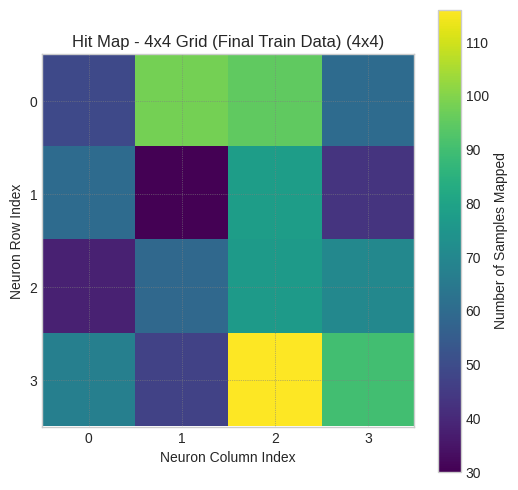

Number of dead neurons found: 0 (0.0%)

Generating sample images plot for 4x4 Grid (Final Train Data)...


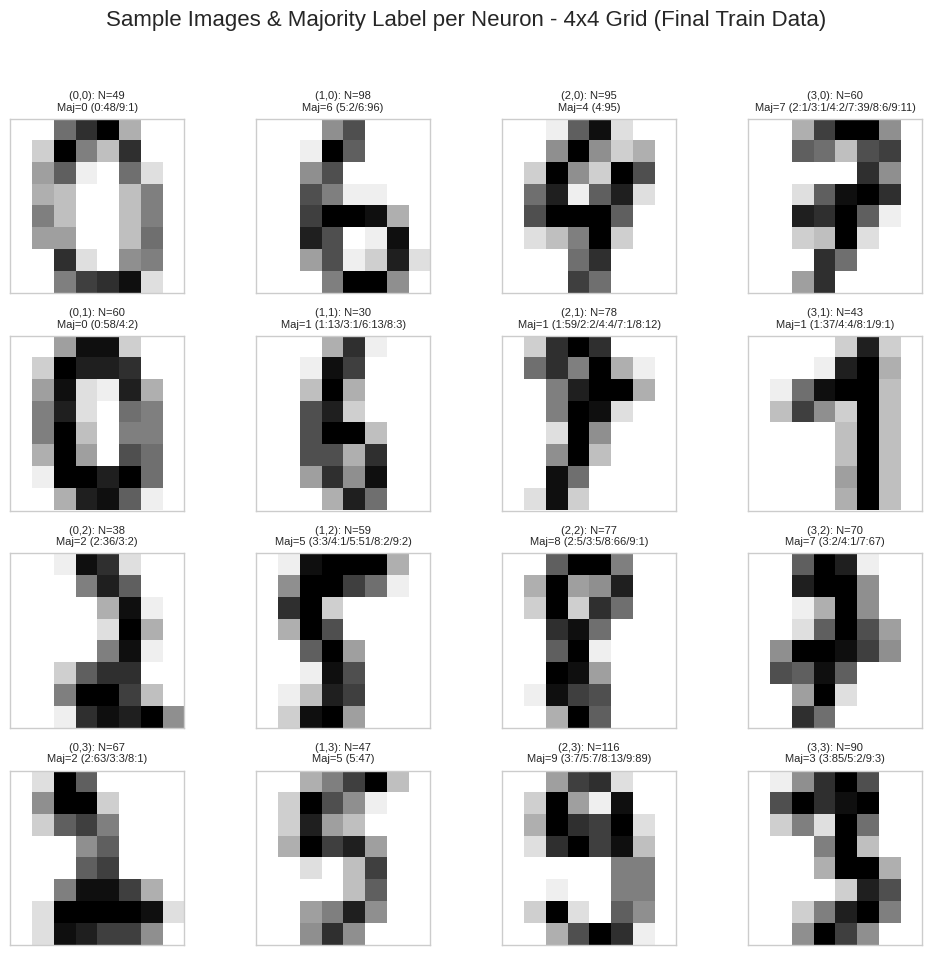

------------------------------


In [10]:
print("\nVisualizing 4x4 SOM based on FINAL Training Data:")
neuron_labels_map_small, dead_neurons_small = visualize_som_clusters(
    som_small,
    X_train_final,
    y_train_final,
    X_train_final_orig,
    som_grid_size_small,
    "4x4 Grid (Final Train Data)"
)
print("-" * 30)


Visualizing 20x20 SOM based on FINAL Training Data:

--- Visualizing SOM Clusters: 20x20 Grid (Final Train Data) ---
Hit Map Analysis (20x20 Grid (Final Train Data)):
  Min hits per neuron = 0
  Max hits per neuron = 14
  Avg hits per neuron = 2.69


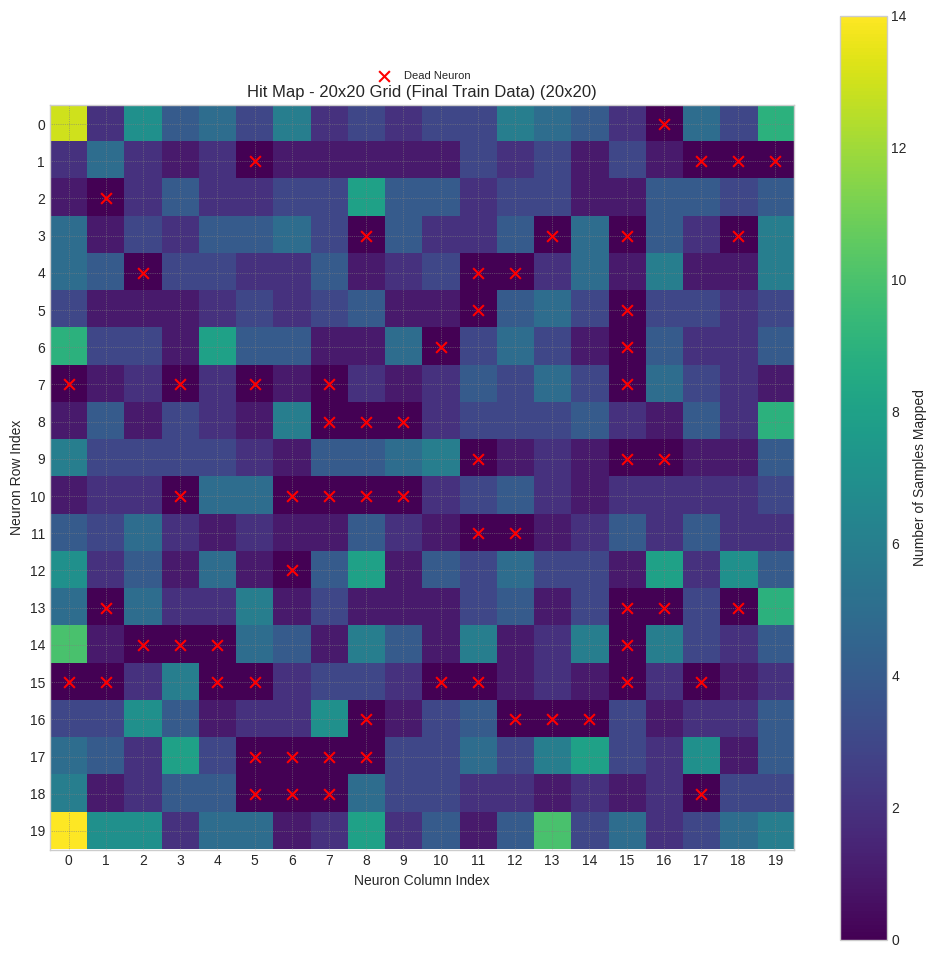

Number of dead neurons found: 64 (16.0%)

Generating sample images plot for 20x20 Grid (Final Train Data)...


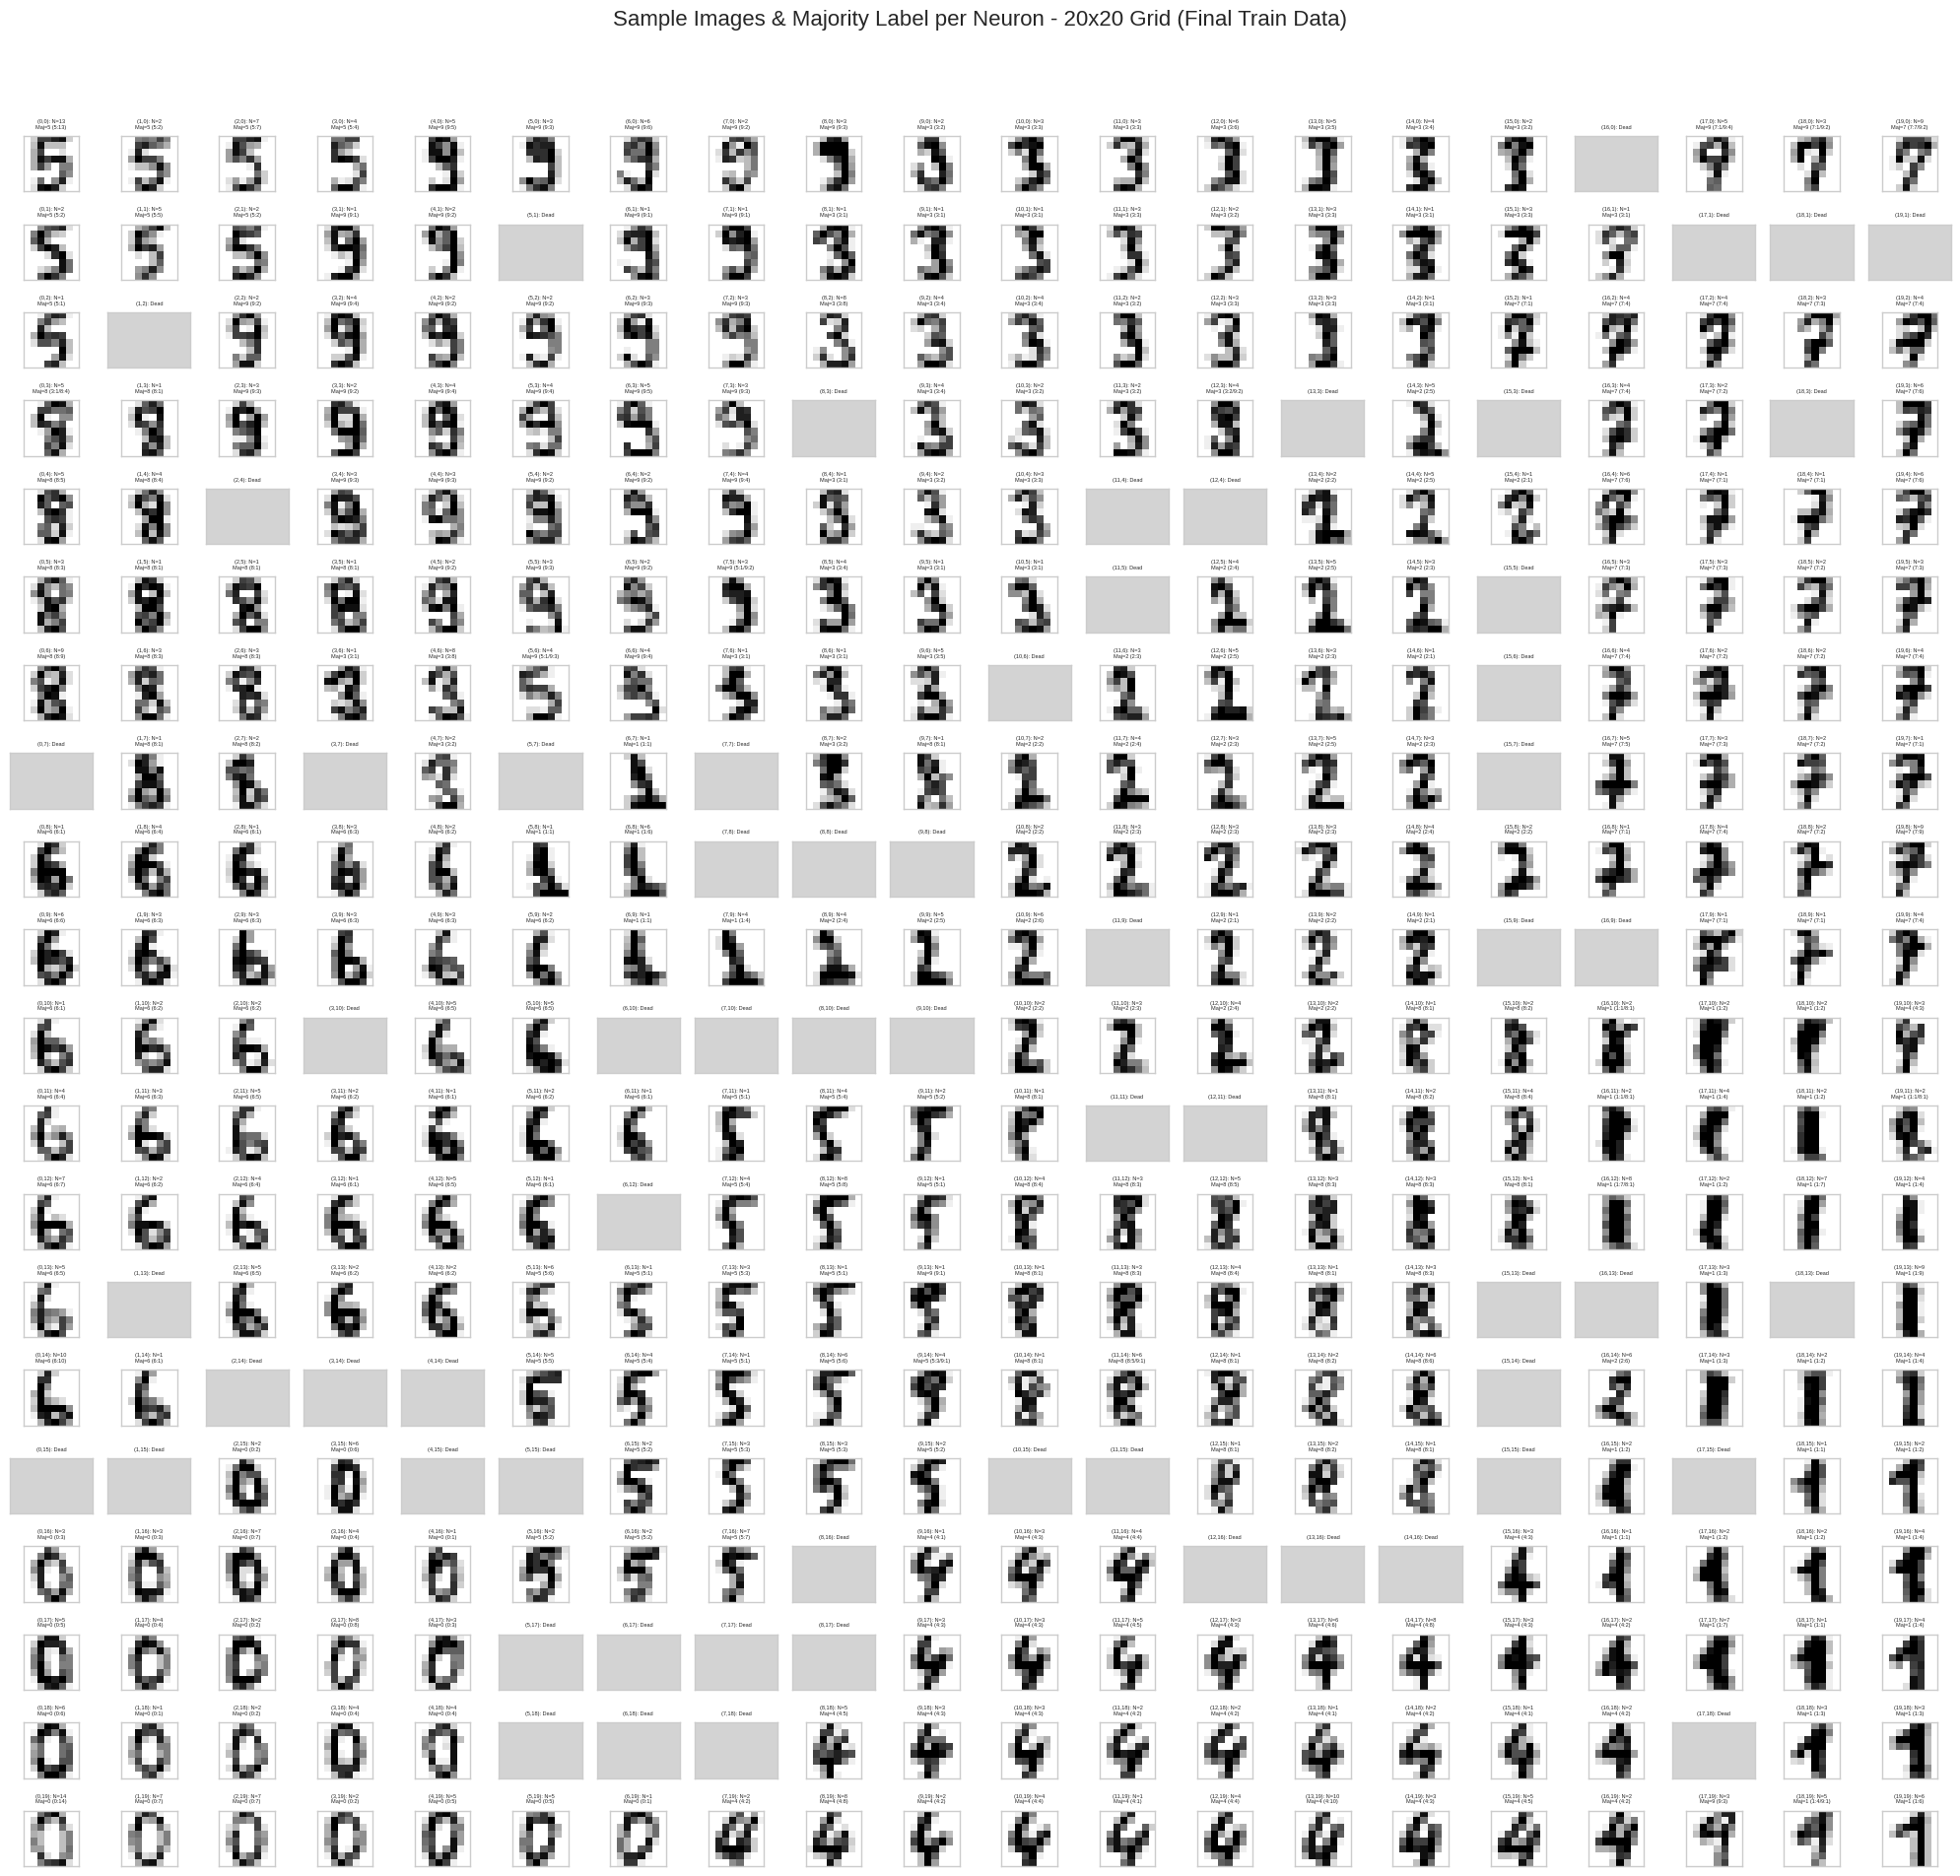

------------------------------


In [11]:
print("\nVisualizing 20x20 SOM based on FINAL Training Data:")
neuron_labels_map_large, dead_neurons_large = visualize_som_clusters(
    som_large,
    X_train_final,
    y_train_final,
    X_train_final_orig,
    som_grid_size_large,
    "20x20 Grid (Final Train Data)"
)
print("-" * 30)